# Boulanger/Fejzo/Rimmert, Measuring Bibliometric Coverage of German Law Journals

Some of the following code snippets only work if you have access to the databases of the Kompetenznetzwerk Bibliometrie at the FIZ Karlsruhe. This currently requires the affiliation with one of the participating institutions. 

## Prerequisites and configuration

In [37]:
%load_ext sql
%config SqlMagic.displaylimit = 20
%load_ext autoreload
%autoreload 2

The sql extension is already loaded. To reload it, use:
  %reload_ext sql
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


If you want to run the sql queries, you need to configure the sql adapter with your KB credentials. This requires an `.env` file having the following entries:
```
KB_HOST='<host name as as per KB instructions>'
KB_DB='<database name as per KB instructions>'
KB_PORT=<port as per KB instructions>
KB_USER='<Your user name>'
KB_PASS='<Your password>'
```

You also need to connect to the KB via VPN as per KB instructions.

In [4]:
from dotenv import load_dotenv
from sqlalchemy import URL, create_engine
import os
load_dotenv('.env')
url = URL.create(
    "postgresql",
    host=os.environ['KB_HOST'],
    port=os.environ['KB_PORT'],
    database=os.environ['KB_DB'],
    username=os.environ['KB_USER'],
    password=os.environ['KB_PASS']
)
engine = create_engine(url)
%sql engine --alias kb_prod

Now you can run sql queries directly in the python notebook. 

Finally, we need to specify which database tables (identified by "schemas") we are going to pull our data from: 

In [5]:
version_name = "202408"
result_schema = "project_rewi"
wos_bdb_schema = "wos_b_202407"
scp_bdb_schema = "scp_b_202407"
openalex_bdb_schema = "fiz_openalex_bdb_20240831_openbib"
openalex_rep_schema = "fiz_openalex_rep_20240831_openbib"
crossref_table = "open_add_ons.cr_oct2023"

## Fig. 1: Legal scholarship journals in the ZDB

Number of active serial publications classified as DDC 340 (“law”) and language “German” in the ZDB, per year, via lobid.org. For details, see [rewi-journals-zdb.ipynb](./rewi-journals-zdb.ipynb).

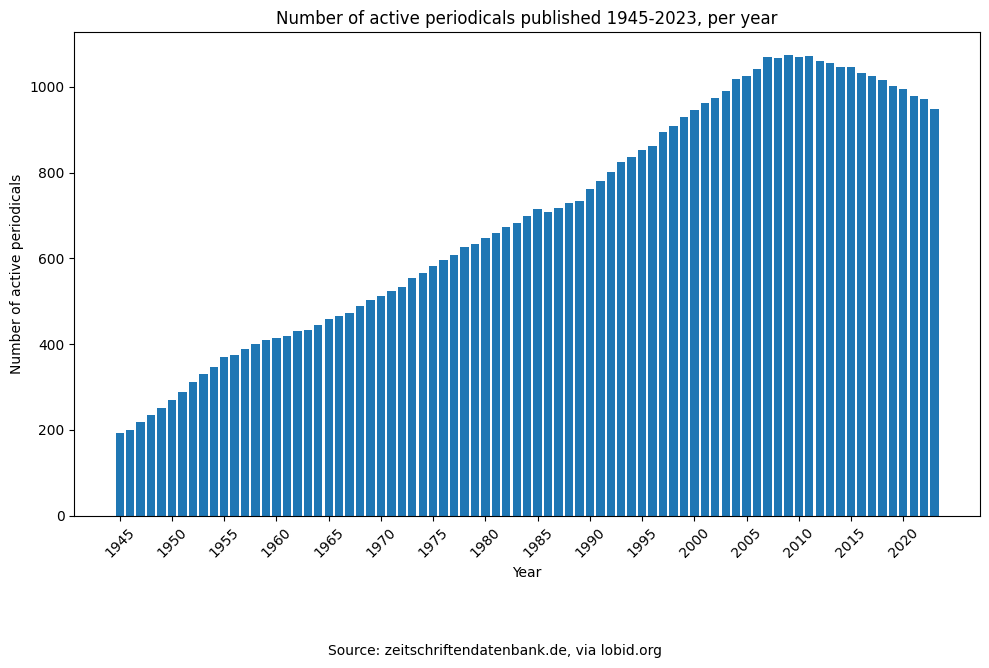

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('data/zdb/zdb-ger-law-issn-1945-2023-years.csv', encoding='utf-8')

plt.figure(figsize=(10, 6))
plt.bar(df['year'], df['number_of_journals'])
plt.xticks(df['year'][df['year'] % 5 == 0], rotation=45)
plt.xlabel('Year')
plt.ylabel('Number of active periodicals')
plt.title('Number of active periodicals published 1945-2023, per year')
plt.figtext(0.5, -0.1, "Source: zeitschriftendatenbank.de, via lobid.org", ha="center", fontsize=10)
plt.tight_layout()
plt.savefig('plots/periodicals_published_timeline.png', dpi=300, bbox_inches='tight')
plt.show()

## Table 1: Articles in WoS Core Collection categorized "German" and "Law"

(Details in [this notebook](./evaluations_rewi_journal_lists.ipynb))

In [38]:
%%sql
select source_title as "Journal", 
    article_count as "Number of Articles", 
    law_and_de as "Number of German Law Articles",
    law_and_de_article_share as "Share of German Law Articles"
from  {{result_schema}}.eva_wos_de_law_journals_trivial_search_result_{{version_name}};

Running query in 'kb_prod'

2 rows affected.

Journal,Number of Articles,Number of German Law Articles,Share of German Law Articles
kriminologisches journal,79,74,0.94
tijdschrift voor rechtsgeschiedenis-revue d histoire du droit-the legal history review,279,44,0.16


In [39]:
from utils.notebook_utils import resultset_to_md
resultset_to_md(_, sort_by="Share of German Law Articles", minimal=True)  

| Journal | Number of Articles | Number of German Law Articles | Share of German Law Articles |
|:---|---:|---:|---:|
| kriminologisches journal | 79 | 74 | 0.94 |
| tijdschrift voor rechtsgeschiedenis-revue d histoire du droit-the legal history review | 279 | 44 | 0.16 |


## Table 2: Articles in Scopus categorized "German" and "Law"

(Details in [this notebook](./evaluations_rewi_journal_lists.ipynb))

In [45]:
%%sql
select array_to_string(source_title, '/', '') as "Journal", 
    article_count as "Number of Articles", 
    law_and_de as "Number of German Law Articles",
    law_and_de_article_share as "Share of German Law Articles"
from  {{result_schema}}.eva_scp_de_law_journals_trivial_search_result_{{version_name}}
order by law_and_de_article_share desc


Running query in 'kb_prod'

23 rows affected.

Journal,Number of Articles,Number of German Law Articles,Share of German Law Articles
Kriminalistik,2601,2599,1.00
Verwaltung,115,114,0.99
Osterreichisches Archiv fur Recht und Religion,168,166,0.99
"Forensische Psychiatrie, Psychologie, Kriminologie",523,513,0.98
"Zeitschrift der Savigny-Stiftung fur Rechtsgeschichte, Germanistische Abteilung",398,373,0.94
Kriminologisches Journal,207,184,0.89
Monatsschrift fur Kriminologie und Strafrechtsreform,323,284,0.88
Deutsche Lebensmittel-Rundschau,1739,1478,0.85
"Zeitschrift der Savigny-Stiftung fur Rechtsgeschichte, Romanistische Abteilung",603,500,0.83
"Zeitschrift der Savigny-Stiftung fur Rechtsgeschichte, Kanonistische Abteilung",120,93,0.78


In [48]:
from utils.notebook_utils import resultset_to_md
resultset_to_md(_, minimal=True)  


| Journal | Number of Articles | Number of German Law Articles | Share of German Law Articles |
|:---|---:|---:|---:|
| Kriminalistik | 2601 | 2599 | 1 |
| Verwaltung | 115 | 114 | 0.99 |
| Osterreichisches Archiv fur Recht und Religion | 168 | 166 | 0.99 |
| Forensische Psychiatrie, Psychologie, Kriminologie | 523 | 513 | 0.98 |
| Zeitschrift der Savigny-Stiftung fur Rechtsgeschichte, Germanistische Abteilung | 398 | 373 | 0.94 |
| Kriminologisches Journal | 207 | 184 | 0.89 |
| Monatsschrift fur Kriminologie und Strafrechtsreform | 323 | 284 | 0.88 |
| Deutsche Lebensmittel-Rundschau | 1739 | 1478 | 0.85 |
| Zeitschrift der Savigny-Stiftung fur Rechtsgeschichte, Romanistische Abteilung | 603 | 500 | 0.83 |
| Zeitschrift der Savigny-Stiftung fur Rechtsgeschichte, Kanonistische Abteilung | 120 | 93 | 0.78 |
| Recht und Psychiatrie | 369 | 284 | 0.77 |
| Zeitschrift fur Rechtssoziologie | 89 | 63 | 0.71 |
| Kriminologie | 94 | 66 | 0.7 |
| Jusletter IT | 708 | 446 | 0.63 |
| Archiv fur 

## Table 3: OpenAlex results, top 20 by number of articles

In [50]:
%%sql
select display_name as "Journal", 
    works_count as "Number of Articles", 
    law_and_de as "Number of German Law Articles",
    law_and_de_article_share as "Share of German Law Articles"
from  {{result_schema}}.eva_openalex_de_law_journals_trivial_search_result_{{version_name}}
order by law_and_de_article_share desc

Running query in 'kb_prod'

323 rows affected.

Journal,Number of Articles,Number of German Law Articles,Share of German Law Articles
Zeitschrift für Beihilfenrecht,253,191,0.75
"Computer Und Recht: Forum für die Praxis des Rechts der Datenverargeitung, Information und Automation",2332,1664,0.71
Zeitschrift für Informationsrecht,1963,1403,0.71
Jura - Juristische Ausbildung,24,17,0.71
Europaische grundrechte zeitschrift,334,236,0.71
Datenschutz und Datensicherheit,20,14,0.70
Jus: Juristische Schulung,1487,1030,0.69
Europaisches wirtschafts und steuerrecht,382,260,0.68
Schweizerisches Zentralblatt für Staats- und Verwaltungsrecht,102,69,0.68
Jahrbuch Eigentum und Urheberrecht in der Demokratie,21,14,0.67


In [51]:
from utils.notebook_utils import resultset_to_md
resultset_to_md(_, minimal=True, limit=20)  

| Journal | Number of Articles | Number of German Law Articles | Share of German Law Articles |
|:---|---:|---:|---:|
| Zeitschrift für Beihilfenrecht | 253 | 191 | 0.75 |
| Computer Und Recht: Forum für die Praxis des Rechts der Datenverargeitung, Information und Automation | 2332 | 1664 | 0.71 |
| Zeitschrift für Informationsrecht | 1963 | 1403 | 0.71 |
| Jura - Juristische Ausbildung | 24 | 17 | 0.71 |
| Europaische grundrechte zeitschrift | 334 | 236 | 0.71 |
| Datenschutz und Datensicherheit | 20 | 14 | 0.7 |
| Jus: Juristische Schulung | 1487 | 1030 | 0.69 |
| Europaisches wirtschafts und steuerrecht | 382 | 260 | 0.68 |
| Schweizerisches Zentralblatt für Staats- und Verwaltungsrecht | 102 | 69 | 0.68 |
| Jahrbuch Eigentum und Urheberrecht in der Demokratie | 21 | 14 | 0.67 |
| Zeitschrift für Zivilprozess | 483 | 325 | 0.67 |
| WUW : Wirtschaft und wettbewerb = Concurrence et marché = Competition and trade regulation | 767 | 517 | 0.67 |
| ZG : Zeitschrift für Gesetzgebung | 377

## Fig. 2: Intersection (by abbreviation) of online journal lists

In [8]:
%pip install  --quiet venny4py

Note: you may need to restart the kernel to use updated packages.


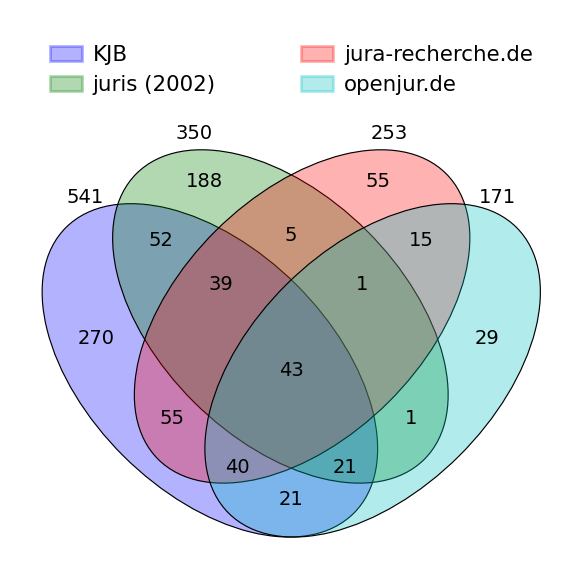

In [55]:
import pandas as pd 
from venny4py.venny4py import venny4py 

sets = {
    'KJB': 'data/web_lists/karlsruher-juristische-bibliographie-2024-12-13.csv',
    'juris (2002)': 'data/web_lists/juris-ingested-journals-2002.csv',
    'jura-recherche.de': 'data/web_lists/jura-recherche.de-2024-12-13.csv',
    'openjur.de': 'data/web_lists/openjur.de-2024-12-13.csv'
}
abbrevs = {}
for set_name, file_path in sets.items():
    df = pd.read_csv(file_path)
    abbreviations = df['abbreviation'].dropna().str.lower().tolist()
    abbrevs[set_name] = set(segment.lower().strip() for abbrev in abbreviations for segment in abbrev.split(',') if segment.strip())

venny4py(sets=abbrevs, out="tmp")

## Fig. 3: Intersection (by abbreviation) between KJB, juris and Wikipedia entries

For details, see [rewi-journals-wikipedia.ipynb](./rewi-journals-wikipedia.ipynb)

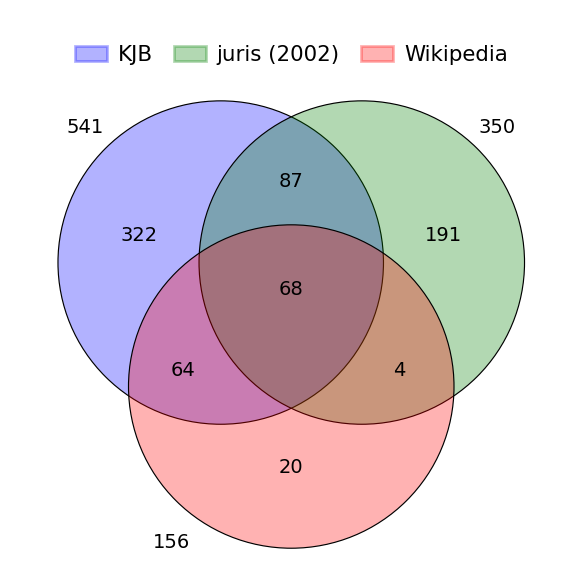

In [56]:
import pandas as pd 
from venny4py.venny4py import venny4py 

sets = {
    'KJB': 'data/web_lists/karlsruher-juristische-bibliographie-2024-12-13.csv',
    'juris (2002)': 'data/web_lists/juris-ingested-journals-2002.csv',
    'Wikipedia': 'data/wikipedia/category-law-journal-germany-with-issn.csv',
}
abbrevs = {}
for set_name, file_path in sets.items():
    df = pd.read_csv(file_path)
    abbreviations = df['abbreviation'].dropna().str.lower().tolist()
    abbrevs[set_name] = set(segment.lower().strip() for abbrev in abbreviations for segment in abbrev.split(',') if segment.strip())

venny4py(sets=abbrevs, out="tmp")

## Fig. 4: Inclusion of journal source set (Y-axis) in journal target set (X-Axis)

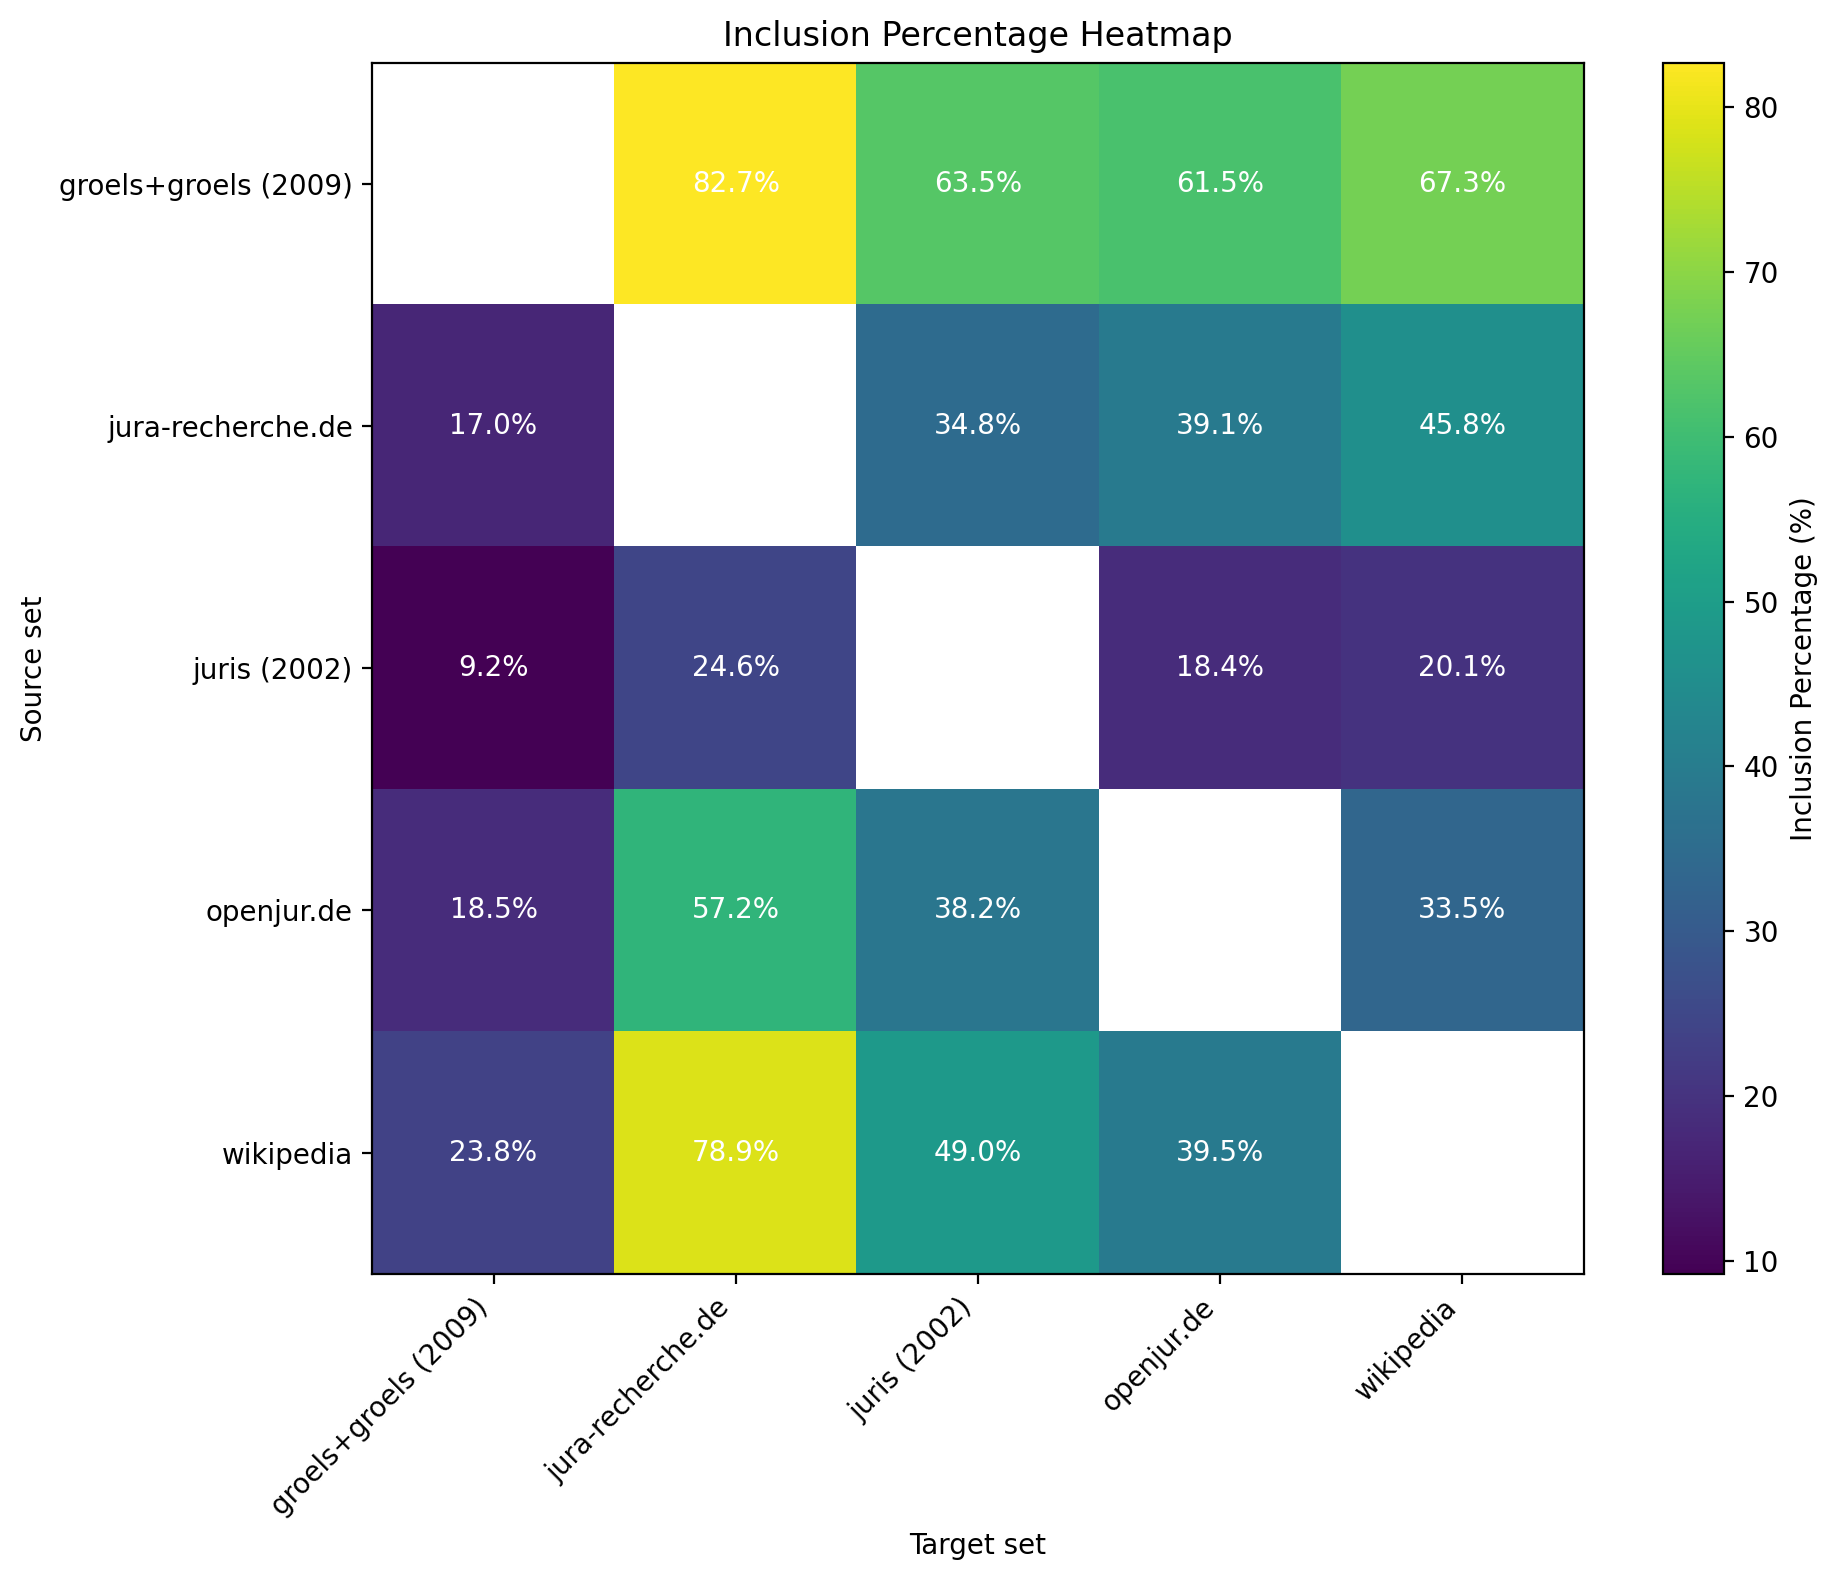

In [58]:
from lib.intersections import compute_csv_intersections, heatmap_inclusion_percentage
data = {
    'groels+groels (2009)': 'data/gold/gold-groels-groels-2009.csv', 
    'jura-recherche.de': 'data/web_lists/jura-recherche.de-2024-12-13.csv',
    'juris (2002)': 'data/web_lists/juris-ingested-journals-2002.csv',
    'openjur.de': 'data/web_lists/openjur.de-2024-12-13.csv',
    'wikipedia': 'data/wikipedia/category-law-journal-germany-with-issn.csv'
}

labels, paths = zip(*data.items())
matrix = compute_csv_intersections(paths, by='abbreviation', lowercase=True, separator=',')
heatmap_inclusion_percentage(matrix, labels=labels)

## Table 4: List of 52 most important Law Journals, as ranked by Gröls/Gröls (2009)

In [7]:
import pandas as pd
from utils.notebook_utils import df_to_md
df = pd.read_csv("data/gold/gold-groels-groels-2009.csv")
df = df[['abbreviation', 'title']]
df.columns = ['Abbreviation', 'Title']
df_to_md(df, minimal=True, sort_by='Title', ascending=True)  

| Abbreviation | Title |
|:---|:---|
| AuR | Arbeit und Recht |
| AVR | Archiv des Volkerrechts |
| AöR | Archiv des öffentlichen Rechts |
| AcP | Archiv für die civilistische Praxis |
| BB | Betriebs-Berater |
| CR | Computer und Recht |
| DB | DER BETRIEB |
| Staat | Der Staat |
| StV | Der Strafverteidiger |
| DStR | Deutsches Steuerrecht |
| DVBI | Deutsches Verwaltungsblatt |
| AG | Die Aktiengesellschaft |
| Verw | Die Verwaltung |
| DOV | Die öffentliche Verwaltung |
| EuR | Europarecht |
| EuGRZ | Europäische Grundrechtezeitschrift |
| EuZW | Europäische Zeitschrift für Wirtschaftsrecht |
| GmbHR | GmbH-Rundschau |
| GA | Goltdammers Archiv für Strafrecht |
| JZ | JuristenZeitung |
| JA | Juristische Arbeitsblätter |
| JURA | Juristische Ausbildung |
| JR | Juristische Rundschau |
| JuS | Juristische Schulung |
| KJ | Kritische Justiz |
| KritV | Kritische Vierteljahresschrift für Gesetzgebung und Rechtswissenschaft |
| MDR | Monatsschrift für Deutsches Recht |
| NZS | Neue Zei

## Coverage of 

In [24]:
import pandas as pd
from utils.notebook_utils import df_to_md
data = []
for db in ['wos', 'scp', 'openalex']:
    df = pd.read_csv(f"data/kb_data/202408/eva_{db}_de_law_journals_trivial_search_result_202408.csv")
    hits = df[df['in_goldstandard'] == True].shape[0]
    data.append([db, hits])
result = pd.DataFrame(data, columns=['Database', 'Gold standard journals'])
df_to_md(result, minimal=True)

| Database | Gold standard journals |
|:---|---:|
| wos | 0 |
| scp | 5 |
| openalex | 32 |


## Compare ranking in OpenAlex with Gröls/Gröls, generalist journals

In [57]:
%%sql
WITH 
 groels_qual_gew AS (
  SELECT 
    abk,
    qualitaet_gewichtet,
    ROW_NUMBER() OVER (ORDER BY qualitaet_gewichtet DESC) AS ranking
  FROM 
    project_rewi.jura_groels_tabelle1_allg_zeitschriften
  ),
journal_impact_factors AS (
  SELECT 
    abk,
    ROUND(AVG(journal_impact_factor), 2) AS mean_journal_impact_factor
  FROM 
    project_rewi.eva_journal_impact_factors
  GROUP BY 
    abk
),
combined AS (
  SELECT 
    a.abk,
    jif.mean_journal_impact_factor AS oa_jif,
    b.qualitaet_gewichtet AS gr_qual_gew,
    gqg.ranking as gr_ranking
  FROM 
    project_rewi.eva_all_journals a
  JOIN 
    project_rewi.jura_groels_tabelle1_allg_zeitschriften b ON a.abk = b.abk
  JOIN 
    journal_impact_factors jif ON a.abk = jif.abk
  JOIN 
    groels_qual_gew gqg ON a.abk = gqg.abk
)
SELECT 
  abk,
  oa_jif,
  ROW_NUMBER() OVER (ORDER BY oa_jif DESC) AS ranking_a,
  gr_qual_gew,
  ROW_NUMBER() OVER (ORDER BY gr_ranking) AS ranking_b
FROM 
  combined
ORDER BY 
  ranking_a;



Running query in 'kb_prod'

c:\Users\Boulanger\anaconda3\envs\kb-bibliometry\Lib\site-packages\sql\connection\connection.py:899: JupySQLRollbackPerformed: Server closed connection. JupySQL executed a ROLLBACK operation.
  warnings.warn(


13 rows affected.

abk,oa_jif,ranking_a,gr_qual_gew,ranking_b
Staat,0.15,1,1.03,6
KJ,0.13,2,0.66,9
AcP,0.08,3,5.68,2
AöR,0.07,4,2.66,3
RabelsZ,0.07,5,0.60,11
JZ,0.06,6,10.00,1
KritV,0.05,7,0.57,13
JR,0.04,8,1.12,5
ZRG,0.02,9,0.57,12
ZZP,0.01,10,0.69,8


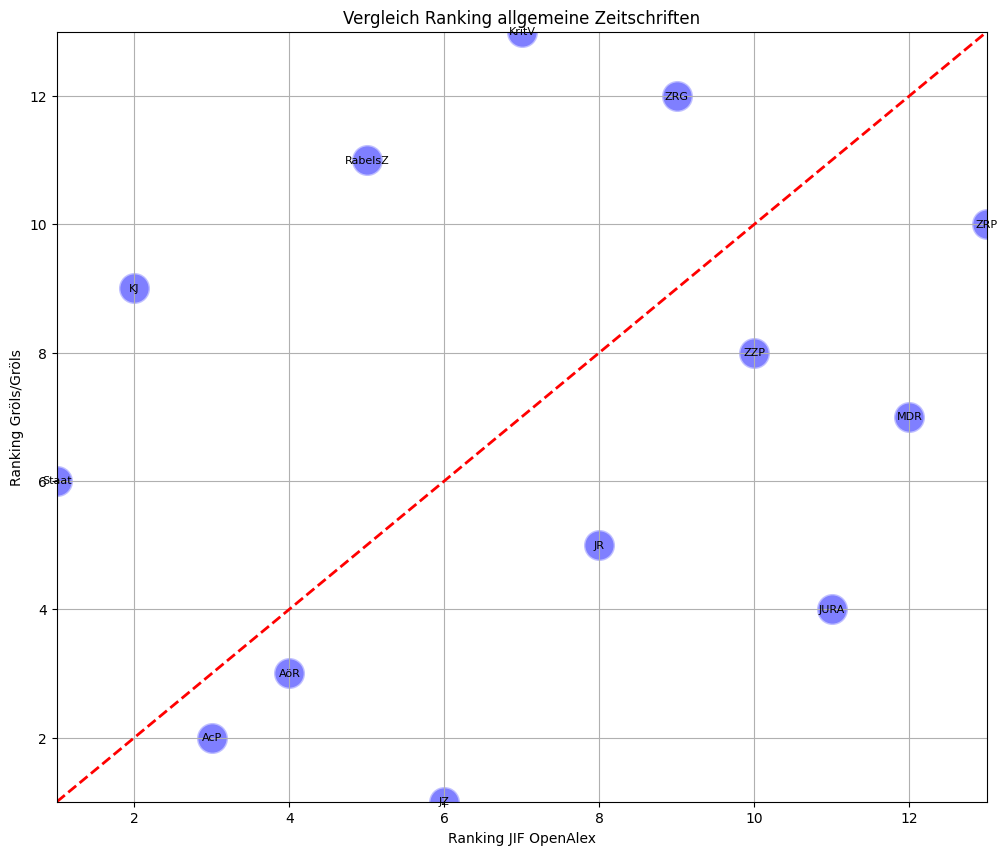

In [5]:
%autoreload 2
from lib.visualizations import compare_rankings
ranking_df = _.DataFrame()
compare_rankings(ranking_df, title='Vergleich Ranking allgemeine Zeitschriften',
                 label_ranking_a='Ranking JIF OpenAlex', label_ranking_b='Ranking Gröls/Gröls')

## Compare ranking in OpenAlex with Gröls, specialized law journals

In [6]:
%%sql
WITH 
 groels_qual_gew AS (
  SELECT 
    abk,
    qualitaet_gewichtet,
    ROW_NUMBER() OVER (ORDER BY qualitaet_gewichtet DESC) AS ranking
  FROM 
    project_rewi.jura_groels_tabelle2_fachspez_zeitschriften
  ),
journal_impact_factors AS (
  SELECT 
    abk,
    ROUND(AVG(journal_impact_factor), 2) AS mean_journal_impact_factor
  FROM 
    project_rewi.eva_journal_impact_factors
  GROUP BY 
    abk
),
combined AS (
  SELECT 
    a.abk,
    jif.mean_journal_impact_factor AS oa_jif,
    b.qualitaet_gewichtet AS gr_qual_gew,
    gqg.ranking as gr_ranking
  FROM 
    project_rewi.eva_all_journals a
  JOIN 
    project_rewi.jura_groels_tabelle2_fachspez_zeitschriften b ON a.abk = b.abk
  JOIN 
    journal_impact_factors jif ON a.abk = jif.abk
  JOIN 
    groels_qual_gew gqg ON a.abk = gqg.abk
)
SELECT 
  abk,
  oa_jif,
  ROW_NUMBER() OVER (ORDER BY oa_jif DESC) AS ranking_a,
  gr_qual_gew,
  ROW_NUMBER() OVER (ORDER BY gr_ranking) AS ranking_b
FROM 
  combined
ORDER BY 
  ranking_a;



Running query in 'kb_prod'

22 rows affected.

abk,oa_jif,ranking_a,gr_qual_gew,ranking_b
ZaoRV,1.40,1,2.38,17
Staat,0.15,2,8.24,4
DVBI,0.15,3,6.08,9
EuR,0.13,4,2.19,19
AVR,0.09,5,2.2,18
Verw,0.09,6,4.62,10
AcP,0.08,7,3.21,14
AöR,0.07,8,9.63,1
ZGR,0.07,9,9.42,2
RabelsZ,0.07,10,2.41,16


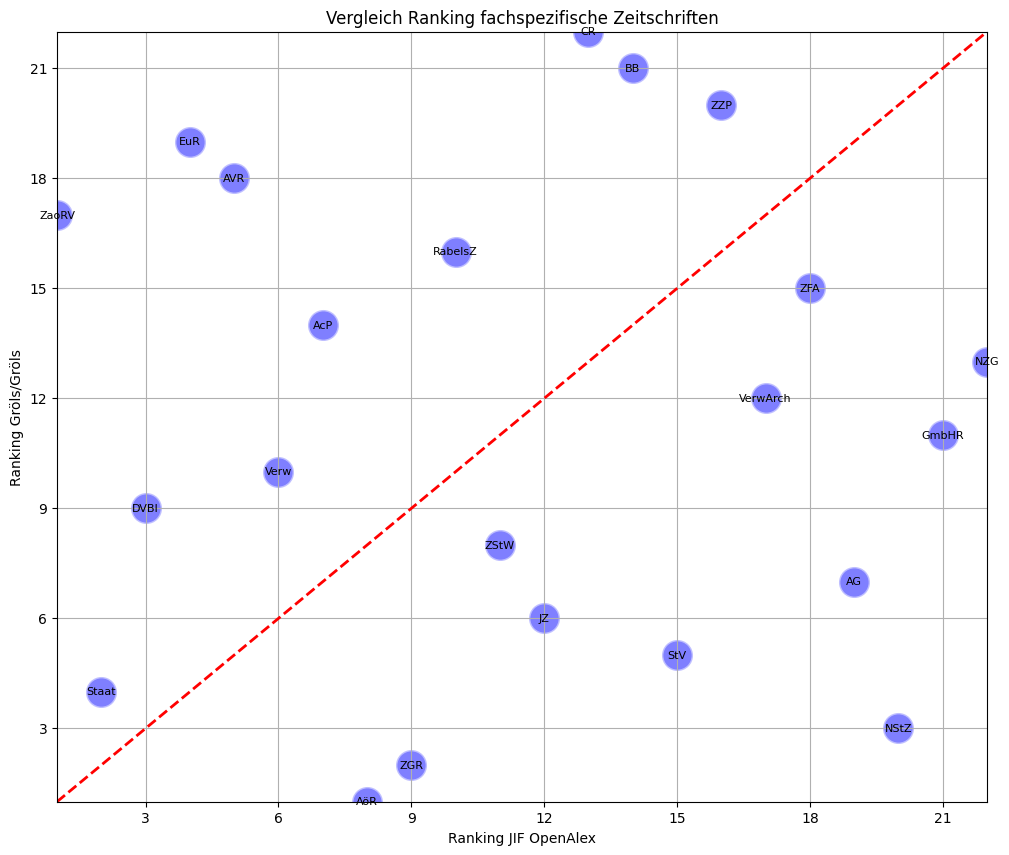

In [7]:
%autoreload 2
from lib.visualizations import compare_rankings
ranking_df = _.DataFrame()
compare_rankings(ranking_df, title='Vergleich Ranking fachspezifische Zeitschriften',
                 label_ranking_a='Ranking JIF OpenAlex', label_ranking_b='Ranking Gröls/Gröls')